In [1]:
include(joinpath(pwd(), "MPC_functions.jl"))
using  Luna
import FFTW                    
import Luna: Hankel  
import NumericalIntegration: integrate, SimpsonEven          
import Dates                   
using LaTeXStrings
using Printf
using DSP
using HDF5
using PyPlot
pygui(true)
using Plots
using DelimitedFiles

In [2]:
save_figs = false

PyPlot.rcdefaults() # reset to default
PyPlot.close("all")

# Set global plotting parameters for PyPlot.jl
PyPlot.rc("font", size=12)      #family="serif",
# PyPlot.rc("axes", titlesize=18, labelsize=16)
# PyPlot.rc("xtick", labelsize=12)
# PyPlot.rc("ytick", labelsize=12)
PyPlot.rc("lines", linewidth=2)
size_py = 0.393701*[20, 15]     # figure size
size_py_small = 0.393701*[20, 10]     # figure size
size_py_wide = 0.393701*[20, 8]# figure size in cm
res = 300                       # figure resolution (dpi)

300

In [3]:
# Set global plotting parameters for Plots.jl
default(
#       guidefont = font(16, "Times"),    # Axis label font
#       tickfont = font(14),              # Axis tick font
#       legendfontsize = 12,              # Legend font size
#       titlefont = font(18, "Arial"),    # Title font
        linewidth=2
  )
size_jl=(800,600)   # figure size in pixel
# closeall()


(800, 600)

In [4]:
out_path = joinpath(pwd(), "..", "..", "thesis")


"\\\\win.desy.de\\home\\muelderk\\My Documents\\MPC\\MPC_sim_Luna\\..\\..\\thesis"

## READ IN EXPERIMENTAL SPECTRUM

In [5]:
file_path = joinpath("output_thesis", "Spectrum_after_MPC_50kHz_in_1.5barKr_last_configuration_15 roundtrips.txt")

#spectrum
data = readdlm(file_path, '\t', skipstart=14)
λ_exp = data[:,1]   
Iλ_exp = data[:,2]

2048-element Vector{Float64}:
 52.0
 49.0
 57.0
 49.0
 48.0
 48.0
 57.0
 55.0
 59.0
 59.0
  ⋮
 75.0
 69.0
 61.0
 70.0
 65.0
 67.0
 62.0
 66.0
 66.0

## READ IN RESULTS FROM ESMERANDOS 1D CODE

In [6]:
# Reading results from Esmerandos script
dir_path = joinpath("output_thesis", "2025-07-29_11-04-47") #"2025-07-23_13-13-40")

#spectrum
file = joinpath(dir_path, "output_spectrum.txt")
data = readdlm(file, '\t', skipstart=1)
λ_esm = data[:,1].*1e-9   
Iλ_esm = data[:,2]
ϕω_esm = data[:,3]

# pulse temporal
file = joinpath(dir_path, "output_pulse.txt")
data = readdlm(file, '\t', skipstart=1) 
t_esm = data[:,1]
It_esm = data[:,2] 
ϕt_esm = data[:,3]

8192-element Vector{Float64}:
   1.25263349276487
   1.05818282314411
   0.915402289013848
   0.814391171904556
   0.749341951096627
   0.715231823043552
   0.70837463336817
   0.73006805527063
   0.801198940779773
   1.06384399907682
   ⋮
 -54.5799157983691
 -54.2019488230099
 -53.9470148514572
 -53.832875256373
 -53.8483967854414
 -54.0008656720187
 -54.2996384180124
 -54.6831478208212
 -55.0318046082515

## READ IN LOW GDD MIRROR DATA

In [7]:
file_low_GDD_mir = joinpath("input", "mirrordata_0fs2.txt")
file_high_GDD_mir = joinpath("input", "mirrordata_-30fs2.txt")

data, header = readdlm(file_low_GDD_mir, '\t', header=true)

wl_low = data[:,1]
R_low = data[:,2]
GDD_low = data[:,3]


data, header = readdlm(file_high_GDD_mir, '\t', header=true)

wl_high = data[:,1]
R_high = data[:,2]
GDD_high = data[:,3]

251-element Vector{Float64}:
    274.602
    440.228
    633.096
    675.624
    288.78
   -409.266
   -796.979
   -692.267
   -414.619
   -191.07
      ⋮
  -1582.87
  -1927.75
  -2446.49
  -3360.49
  -5263.92
  -9981.52
 -24309.7
 -76885.0
 -98453.1

## I) Read data from .h5 file

In [8]:
run = "run_2025_07_23__12_50_53" #"run_2025_07_23__12_50_53"
run_path = joinpath("output_thesis", run)

params = Dict()

# Open file read-only
h5open(joinpath(run_path, "output.h5"), "r") do file
    # List datasets/groups in the file
    println(keys(file))
    
    # Read dataset
    global Eωr0 = read(file["Eωr0"])
    global Eωr_in = read(file["Eωr_in"])
    global Eωr_out = read(file["Eωr_out"])

    # Read beam waists
    global w_z = read(file["w_z"]) 
    global w_min = read(file["w_min"]) 
    global w_mirr = read(file["w_mirr"]) 
    
    global ω = read(file["ω"])
    global t = read(file["t"])
    global r = read(file["r"])
    global z = read(file["z"])

    # file["params"] is a group with keys as parameter names
    param_group = file["params"]
    for name in keys(param_group)
        params[name] = read(param_group[name])
    end
end

["Eωr0", "Eωr_in", "Eωr_out", "params", "r", "t", "w_min", "w_mirr", "w_z", "z", "ω"]


Regenerate Hankel transform matrix "q", simulation grid as well as additional coordinate axes rsym, f and λ

In [9]:
q = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=2)                  # set up discrete Hankel transform matrix, transformation done along 2nd dimension 
q_1D = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=1)               # to be applied to arrays that where integrated over ω, so r becomes 1rst dimension
rsym = Hankel.Rsymmetric(q)                                 # sampled radii [m] mirrored around and including r=0 so that rsym = [–rn, ...-r2, -r1, 0, r1, r2, ..., rn]

L = params["L"]
λ0 = params["λ0"]
λlims = (params["λmin"], params["λmax"])
trange_request = params["trange_request"]

grid = Grid.RealGrid(L, λ0, λlims, trange_request)               # set up time & space grid for gradient approximation
f = ω./2π                      # sampled linear frequencies [Hz]
λ = PhysData.wlfreq.(ω)         # sampled wavelengths [m]
λ[1] = 1.0                        # avoid "Inf" value for DC frequency

┌ Info: Freq limits 0.21 - 0.43 PHz
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:40
┌ Info: Samples needed: 1927.24, samples: 2048, δt = 389.16 as
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:44
┌ Info: Requested time window: 750.0 fs, actual time window: 797.0 fs
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:46
┌ Info: Grid: samples 1024 / 2048, ωmax 4.04e+15 / 8.07e+15
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:78


1.0

## II) Analyze final output (last propagation step of last pass)

### a) Input vs. output spectrum and spectral phase

In [10]:
Eωr0_in = Eωr0[:,1,1]
Eωr0_out = Eωr0[:,end,end]

513-element Vector{ComplexF64}:
  1166.0516382899948 + 0.0im
  -488.3625705505847 + 1061.8274605292893im
    -766.76215856547 - 892.5268470711019im
   1142.320882970604 - 330.78948296512505im
  -172.0385151178064 + 1193.362180704736im
 -1034.6422790931229 - 655.7806248898011im
  1036.9070786190478 - 690.6643374541974im
  217.71779684232806 + 1248.3659481995066im
  -1251.107222187111 - 305.1917619521479im
   789.3646978735147 - 1041.118062069969im
                     ⋮
  1020.6613247921135 + 460.25379729610097im
  -823.2443791592183 + 712.4416661543096im
 -285.10242064980565 - 1015.9042681681036im
  1005.5049472052604 + 176.19792063740883im
  -581.0843635728467 + 798.9852165816616im
 -441.18465583376206 - 851.3738015869874im
   936.0105430450016 - 5.861029288807536im
 -418.75632347850114 + 820.7156415400979im
  -530.5480976091316 - 747.1068004942854im

In [11]:
ϕω_in = unwrap_phase(ω, t, Eωr0_in)
ϕω_out = unwrap_phase(ω, t, Eωr0_out)

ϕω_in = blank_phase(ω, abs2.(Eωr0_in), ϕω_in; level=0.05)
ϕω_out = blank_phase(ω, abs2.(Eωr0_out), ϕω_out; level=0.05)

513-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

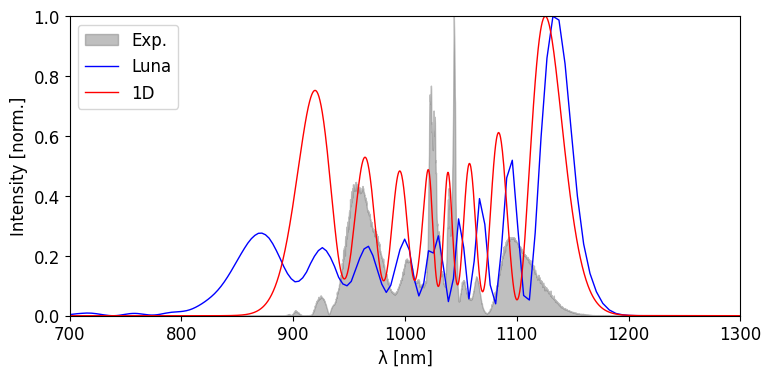

In [48]:
fig, ax1 = plt.subplots(figsize=size_py_small)
# ax1.set_title("Input vs. output spectrum (for r=0)")
# ax1.fill_between(λ.*1e9, Maths.normbymax(abs2.(Eωr0_out)), label="Luna", alpha=1.0)
# ax1.fill_between(λ_esm.*1e9, Maths.normbymax(Iλ_esm), label="1D (Esmerando)", alpha=0.5)
ax1.fill_between(λ_exp, Maths.normbymax(Iλ_exp), label="Exp.", alpha=0.5, color="grey")
ax1.plot(λ.*1e9, Maths.normbymax(abs2.(Eωr0_out)), label="Luna", linewidth=1.0, alpha=1.0, color="blue")
ax1.plot(λ_esm.*1e9, Maths.normbymax(Iλ_esm), label="1D", linewidth=1.0, alpha=1.0, color="red")
# ax2 = ax1.twinx()
# ax2.plot(wl_low, R_low, label="low GDD mirror", color="black", alpha=1.0, linestyle="dotted", linewidth=1.0)
# ax2.plot(λ.*1e9, ϕω_out, label="ϕω_in", color="green")
# ax2.plot(λ_esm.*1e9, ϕω_esm, label="ϕω_out", color="red")
ax1.set_xlim(700, 1300)
# ax1.set_xlim(λlims[1]*1e9, λlims[2]*1e9)
ax1.set_ylim(0,1)
ax2.set_ylim(0,100)

ax1.set_xlabel("λ [nm]")
ax1.set_ylabel("Intensity [norm.]")
# ax2.set_ylabel("phase [rad]")
# ax2.set_ylabel("Reflectivity [%]")
ax1.legend(loc="upper left")
# ax2.legend(loc="upper right")
plt.tight_layout()
# if save_figs 
#     plt.savefig(joinpath(run_path, "spectrum_in_vs_out.png"), dpi=res) 
# end
plt.savefig(joinpath(out_path, "spectrum_Esm_vs_luna_no_mirr.png"), dpi=res) 
plt.gcf()

### b) Input vs. output pulse

In [13]:
Etr0_in = Maths.hilbert(FFTW.irfft(Eωr0_in, length(t), 1))
Etr0_out = Maths.hilbert(FFTW.irfft(Eωr0_out, length(t), 1))

ϕt_in = unwrap(angle.(Etr0_in))
ϕt_out = unwrap(angle.(Etr0_out))

ϕt_in = blank_phase(t, abs2.(Etr0_in), ϕt_in; level=0.05)
ϕt_out = blank_phase(t, abs2.(Etr0_out), ϕt_out; level=0.05)

1024-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

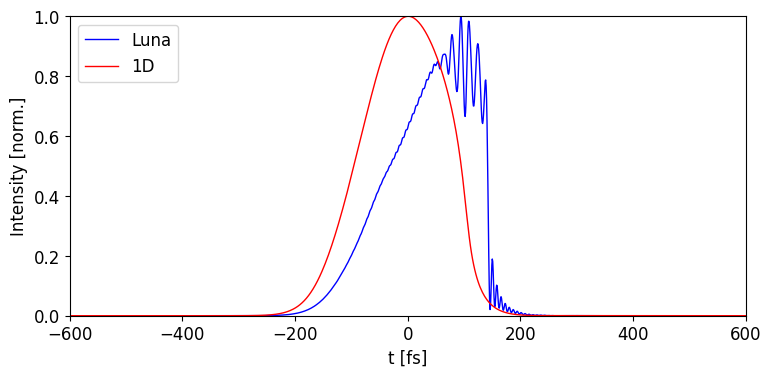

In [47]:
fig, ax1 = plt.subplots(figsize=size_py_small)
# ax1.set_title("Input vs. output pulse (for r=0)")
ax1.plot(t.*1e15, Maths.normbymax(abs2.(Etr0_out)), label="Luna", color="blue", linewidth=1.0)
ax1.plot(-t_esm.*1e15, Maths.normbymax(It_esm), label="1D", color="red", linewidth=1.0)
# ax2 = ax1.twinx()
# ax2.plot(t.*1e15, detrend(ϕt_in), label="ϕt_in", color="green")
# ax2.plot(t.*1e15, detrend(ϕt_out), label="ϕt_out", color="red")
ax1.set_xlim(-600, 600)
ax1.set_ylim(0,1)
ax1.set_xlabel("t [fs]")
ax1.set_ylabel("Intensity [norm.]")
# ax2.set_ylabel("phase [rad]")
ax1.legend(loc="upper left")
# ax2.legend(loc="upper right")
plt.tight_layout()
# if save_figs 
#     plt.savefig(joinpath(run_path, "pulse_in_vs_out.png"), dpi=res) 
# end
plt.savefig(joinpath(out_path, "pulse_Esm_vs_luna_no_mirr.png"), dpi=res) 
plt.gcf()

### c) Spectral homogeinity across r

In [15]:
Irλ_out = transpose(Iwlfreq.(ω, abs2.(Eωr_out)))

128×513 transpose(::Matrix{Float64}) with eltype Float64:
 0.0  3.4021e22   1.37801e23  …  8.02102e27  7.81685e27  7.76672e27
 0.0  4.09374e21  1.64972e22     8.27296e27  8.0753e27   8.02799e27
 0.0  3.9648e21   1.60627e22     6.41629e27  6.23139e27  6.18383e27
 0.0  2.52183e21  1.01518e22     5.80276e27  5.61896e27  5.57022e27
 0.0  8.2077e20   3.30783e21     6.68388e27  6.49315e27  6.44427e27
 0.0  1.44038e21  5.79688e21  …  5.73902e27  5.56026e27  5.51314e27
 0.0  6.28032e19  2.58425e20     4.89848e27  4.72827e27  4.68199e27
 0.0  2.84053e21  1.14593e22     5.3394e27   5.1569e27   5.10756e27
 0.0  2.99942e21  1.204e22       4.01112e27  3.84046e27  3.79186e27
 0.0  1.35075e20  5.52351e20     3.16235e27  3.02187e27  2.98154e27
 ⋮                            ⋱  ⋮                       
 0.0  3.2527e19   1.26379e20     2.43868e24  2.48052e24  2.50112e24
 0.0  2.80823e18  1.10957e19  …  4.33028e23  4.44322e23  4.49323e23
 0.0  5.80089e19  2.21613e20     2.51218e24  2.53466e24  2.54881e24


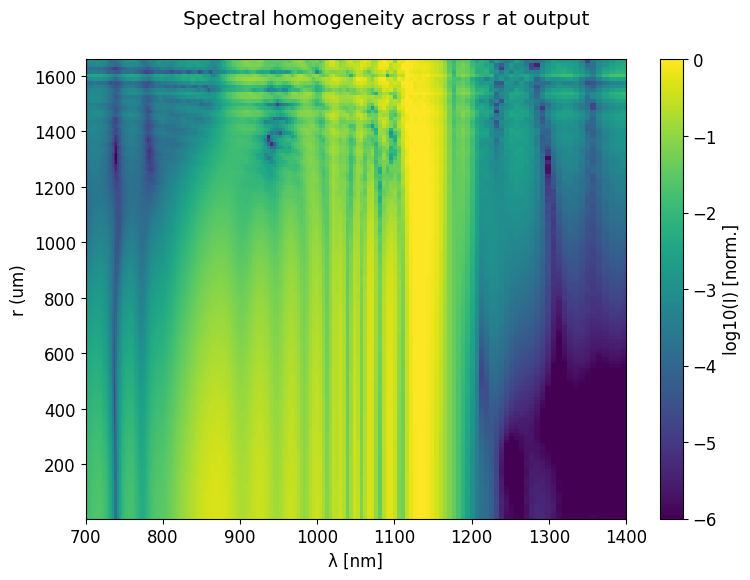

In [16]:
smallval = 1e-50

plt.figure(figsize=size_py)
plt.suptitle("Spectral homogeneity across r at output")
plt.pcolormesh(λ*1e9, r*1e6, Maths.log10_norm(Irλ_out .+smallval, 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log10(I) [norm.]")
plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
plt.xlabel("λ [nm]")
plt.ylabel("r (um)") 
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_homogeneity.png"), dpi=res) 
end
plt.gcf()

### d) Spatiotemporal profile

In [17]:
Etr_out = Maths.hilbert(FFTW.irfft(Eωr_out, length(t), 1))

1024×128 Matrix{ComplexF64}:
    47958.3-2.97092e5im    -58129.4+1.52072e5im  …   1.73828e5-2.67871e5im
  1.95189e5+8917.19im    -1.31581e5-10188.3im         277803.0+94446.8im
    20893.0+1.3267e5im     -16164.5-94995.3im         -18488.0+2.64579e5im
 -1.00415e5+48636.1im       48784.9-22116.0im       -2.30989e5+47155.6im
   -73211.8-78795.2im       13647.1+5345.12im         -96920.9-1.82069e5im
    50294.6-86945.3im       23155.5-1082.83im    …    124452.0-1.27304e5im
    81543.1+10029.6im       14687.8+30880.7im        1.37317e5+65470.0im
    32237.3+54783.8im      -20858.8+22663.6im         -12137.6+1.2859e5im
   -13631.3+59450.4im      -23866.4-2664.4im        -1.05106e5+29823.2im
   -58990.7+28298.3im      -13131.3-19451.9im         -56787.7-72563.4im
           ⋮                                     ⋱  
 -1.02283e6-2.11201e6im    -42073.8+2.7261e5im   …    3.4296e5-2.05633e5im
  1.72033e6-1.03121e6im   -276051.0+5435.2im         2.76561e5+2.94315e5im
  9.89962e5+1.35738e6im    -6

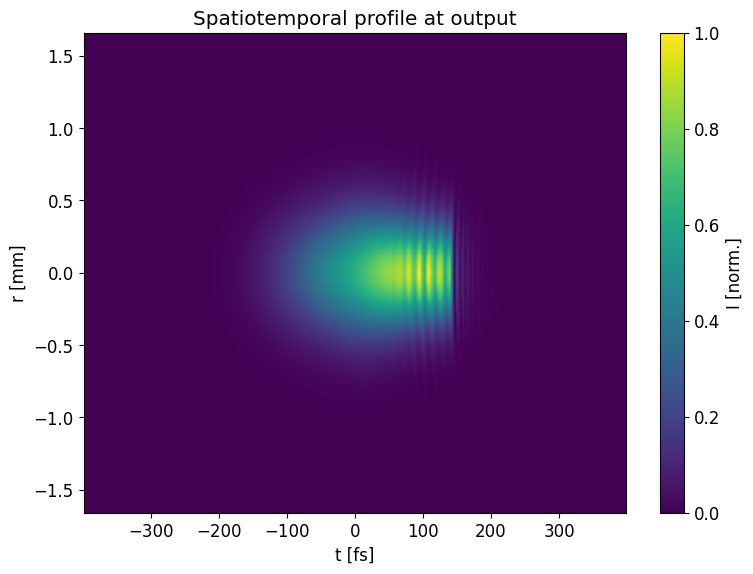

In [18]:
plt.figure(figsize=size_py) 
plt.title("Spatiotemporal profile at output")
plt.pcolormesh(t.*1e15, rsym.*1e3, Maths.normbymax(abs2.(Hankel.symmetric(Etr_out, q)')))
plt.colorbar(label="I [norm.]")
plt.xlabel("t [fs]")
plt.ylabel("r [mm]")
# plt.ylim(minimum(rsym*1e3), maximum(rsym*1e3))
# plt.xlim(minimum(t*1e15)/2, maximum(t*1e15)/2)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spatiotemporal_profile.png"), dpi=res) 
end
plt.gcf()

## III) Analyze overall pulse evolution across all passes

In [19]:
Nω = size(Eωr_in,1)
Nr = size(Eωr_in,2)
Nz = size(Eωr0,2)
Npass = size(Eωr0,3)

Nt = length(t)
Nrsym = length(rsym)

257

In [20]:
z_total = zeros(Nz, Npass)

for pass in 1:Npass 
    z_total[:,pass] = z .+ (pass-1)*z[end]
end

z_total = vcat(z_total...)

6030-element Vector{Float64}:
  0.0
  0.0019135454576426011
  0.0038270909152852022
  0.005740636372927804
  0.0076541818305704045
  0.009567727288213005
  0.011481272745855607
  0.013394818203498207
  0.015308363661140809
  0.01722190911878341
  ⋮
 11.465964382194466
 11.46787792765211
 11.469791473109751
 11.471705018567395
 11.473618564025037
 11.47553210948268
 11.477445654940322
 11.479359200397965
 11.481272745855607

### a) Beams Caustic 

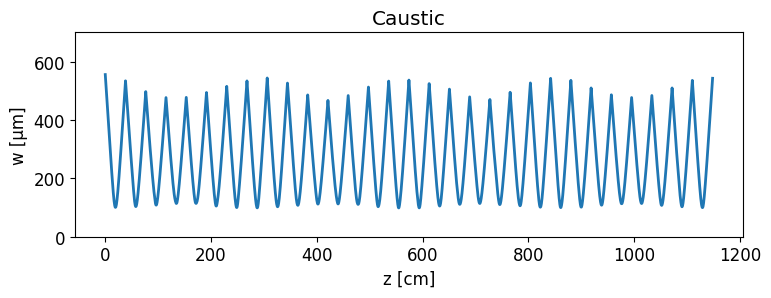

In [21]:
# PLOT CAUSTIC
plt.figure(figsize=size_py_wide) 
plt.title("Caustic")
# plt.plot(z_total.*1e2, cat(dims=1, w_z...).*1e6)
plt.plot(z_total.*1e2, w_z.*1e6)
plt.xlabel("z [cm]")
plt.ylabel("w [μm]")
plt.ylim(0,700)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "caustic.png"), dpi=res) 
end
plt.gcf()

### b) Minimum beam waist per pass

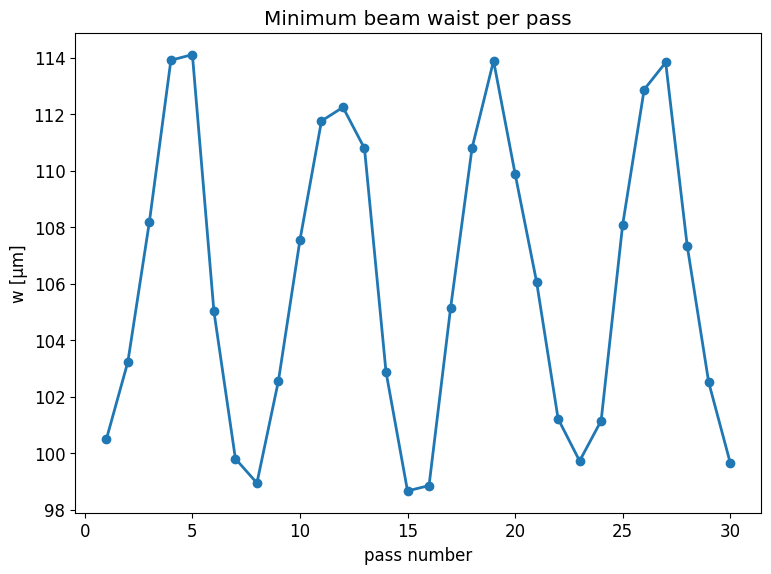

In [22]:
# PLOT minimum beam waist per pass
plt.figure(figsize=size_py) 
plt.title("Minimum beam waist per pass")
plt.plot(1:Npass, w_min.*1e6, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("w [μm]")
# plt.ylim(95,125)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "beam_waist_minimum.png"), dpi=res) 
end
plt.gcf()

### c) Mirror beam waist per pass

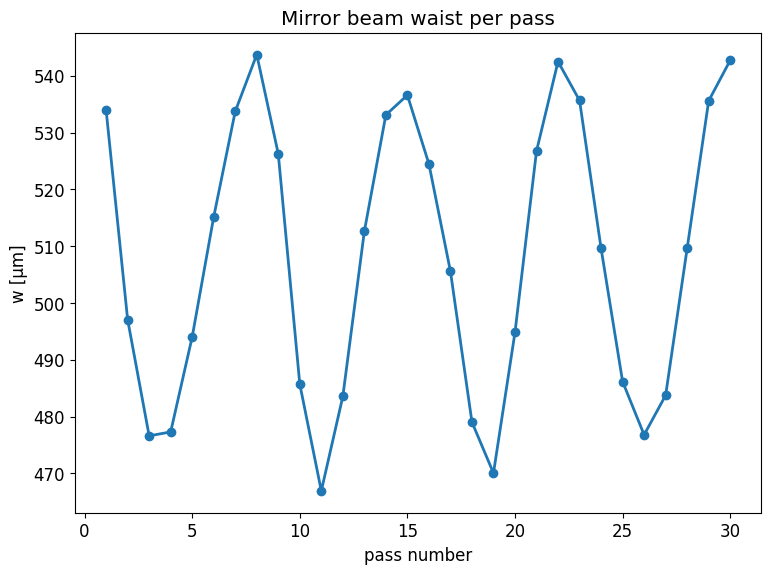

In [23]:
# PLOT mirror beam waist per pass
plt.figure(figsize=size_py) 
plt.title("Mirror beam waist per pass")
plt.plot(1:Npass, w_mirr.*1e6, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("w [μm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

### d) Spectral evolution (vs. λ)

In [24]:
Iωr0 = abs2.(Eωr0)    # convert to intensity
Iλr0 = Iwlfreq.(ω, Iωr0)
Iλr0_fused = hcat(eachslice(Iλr0, dims=3)...)

513×6030 Matrix{Float64}:
 0.0         0.0         0.0         …  0.0         0.0         0.0
 4.42504e24  1.49448e20  6.95143e19     2.08317e23  9.68962e22  4.50703e22
 2.13767e24  2.32083e21  1.07951e21     8.44584e23  3.92849e23  1.8273e23
 4.37274e25  1.118e22    5.20025e21     1.9412e24   9.02929e23  4.19988e23
 1.9565e25   3.29315e22  1.53177e22     3.54714e24  1.64992e24  7.67441e23
 1.0332e26   7.3313e22   3.41007e22  …  5.72093e24  2.66103e24  1.23775e24
 3.33989e26  1.35429e23  6.29932e22     8.52176e24  3.96381e24  1.84372e24
 5.44738e25  2.17926e23  1.01366e23     1.19998e25  5.58157e24  2.59621e24
 1.73602e27  3.13992e23  1.4605e23      1.61865e25  7.52898e24  3.50203e24
 8.35136e26  4.11523e23  1.91416e23     2.10865e25  9.80818e24  4.56217e24
 ⋮                                   ⋱                          
 3.57292e29  1.83293e25  8.52566e24     4.85618e28  2.2588e28   1.05066e28
 3.59844e29  1.51593e25  7.05118e24  …  4.60992e28  2.14426e28  9.97378e27
 3.62415e29  1.29

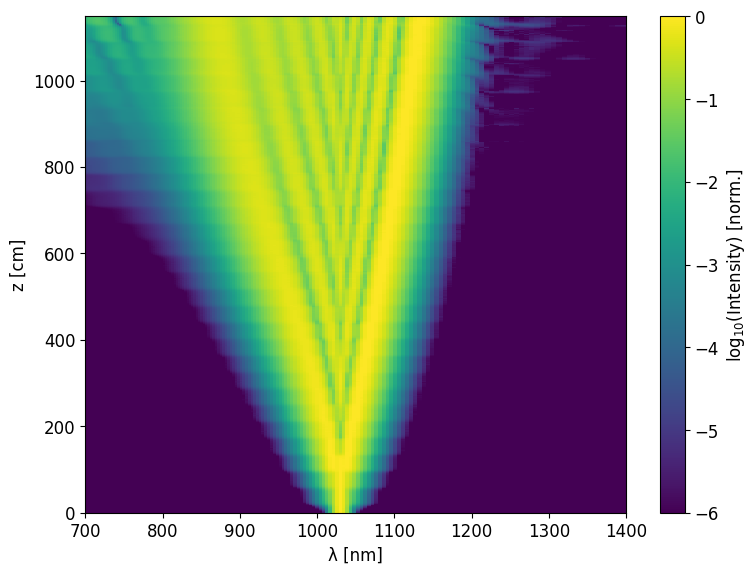

In [25]:
#+++++ PLOT 4: spectral evolution (against λ) 
plt.figure(figsize=size_py)
# plt.suptitle("Spectral evolution at r=0")
plt.pcolormesh(λ.*1e9, z_total.*1e2, Maths.log10_norm(transpose(Iλr0_fused[:, :] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log\$_{10}\$(Intensity) [norm.]")
plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
# plt.ylim(0,75)
plt.xlabel("λ [nm]")
plt.ylabel("z [cm]")
plt.xlim(700,1400)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_wl_log.png"), dpi=res) 
end
plt.gcf()


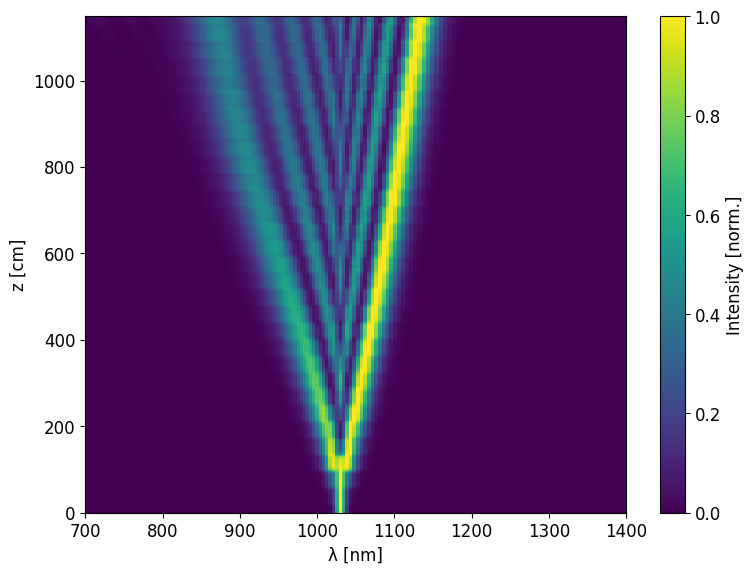

In [26]:
Iλr0_fused = hcat(eachslice(Iλr0, dims=3)...)

#+++++ PLOT 4: spectral evolution (against λ) 
plt.figure(figsize=size_py)
# plt.suptitle("Spectral evolution at r=0")
plt.pcolormesh(λ.*1e9, z_total.*1e2, Maths.normbymax(transpose(Iλr0_fused[:, :]), 2))   
plt.clim(0, 1)    
plt.colorbar(label="Intensity [norm.]")
plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
# plt.ylim(0,75)
plt.xlabel("λ [nm]")
plt.ylabel("z [cm]")
# plt.xlim(700,1400)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_wl.png"), dpi=res) 
end
plt.gcf()

In [27]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(λ.*1e9, Maths.normbymax(Iλr0_fused[:, i]),
#     # size=size_jl,
#     xlim=(λlims[1]*1e9, λlims[2]*1e9), 
#     ylim=(0, 1), 
#     xlabel=("λ [nm]"),
#     ylabel=("I [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2, digits=1)) cm", 
#     title="Spectral evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "spectral_evolution.gif"), fps=24)

In [28]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(λ.*1e9, Maths.log10_norm(Iλr0_fused[:, i] .+smallval), 
#     # size=size_jl,
#     xlim=(λlims[1]*1e9, λlims[2]*1e9), 
#     ylim=(-6, 0), 
#     xlabel=("λ [nm]"),
#     ylabel=("log10(I) [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2, digits=1)) cm", 
#     title="Spectral evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "spectral_evolution_log.gif"), fps=24)

### E) Spectral evolution (vs. f)

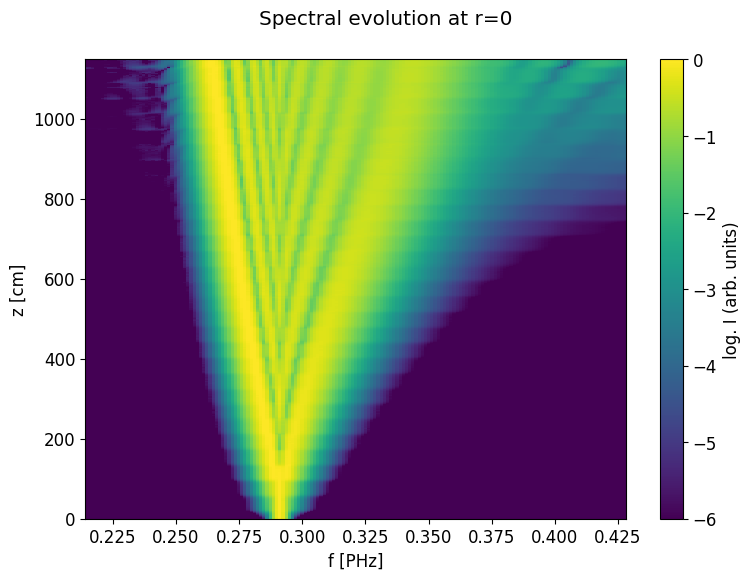

In [29]:
Iωr0_fused = hcat(eachslice(Iωr0, dims=3)...)

#+++++ PLOT 5: spectral evolution (against f) 
plt.figure(figsize=size_py)
plt.suptitle("Spectral evolution at r=0")
plt.pcolormesh(f*1e-15, z_total.*1e2, Maths.log10_norm(transpose(Iωr0_fused[:, :] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(PhysData.wlfreq(λlims[2])/2pi*1e-15, PhysData.wlfreq(λlims[1])/2pi*1e-15)
plt.xlabel("f [PHz]")
plt.ylabel("z [cm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_f.png"), dpi=res) 
end
plt.gcf()

### f) Temporal evolution

In [30]:
Etr0 = zeros((size(Eωr0,1)-1)*2, size(Eωr0,2), size(Eωr0,3))
Itr0 = similar(Etr0)

for pass in 1:size(Eωr0,3)
    Etr0[:,:,pass] = FFTW.irfft(Eωr0[:,:,pass], length(t), 1)  # pulse for r=0
    Itr0[:,:,pass] = abs2.(Maths.hilbert(Etr0[:,:,pass]))           # temporal intensity for r=0
end

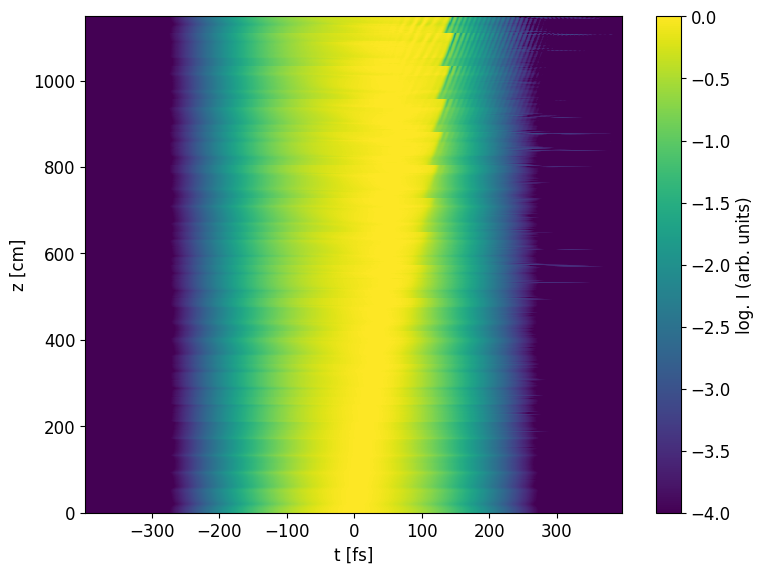

In [31]:
Itr0_fused = hcat(eachslice(Itr0, dims=3)...)

#+++++ PLOT 4: temporal evolution 
plt.figure(figsize=size_py)
# plt.suptitle("Temporal evolution at r=0")
plt.pcolormesh(t.*1e15, z_total.*1e2, Maths.log10_norm(transpose(Itr0_fused[:,:] .+smallval), 2))   
plt.clim(-4, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(minimum(t)*1e15, maximum(t)*1e15)
plt.xlabel("t [fs]")
plt.ylabel("z [cm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "temporal_evolution.png"), dpi=res) 
end
plt.gcf()

In [32]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(t.*1e15, Maths.normbymax(Itr0_fused[:, i]),
#     # size=size_jl,
#     ylim=(0, 1), 
#     xlabel=("t [fs]"),
#     ylabel=("I [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2)) cm", 
#     title="Temporal evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "temporal_evolution.gif"), fps=24)

In [33]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(t.*1e15, Maths.log10_norm(Itr0_fused[:, i] .+smallval),
#     # size=size_jl,
#     ylim=(-6, 0), 
#     xlabel=("t [fs]"),
#     ylabel=("log10(I) [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2)) cm", 
#     title="Temporal evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "temporal_evolution_log.gif"), fps=24)

## B-Integral

In [34]:
I_peak = dropdims(maximum(Itr0, dims=1), dims=1)

201×30 Matrix{Float64}:
 2.43451e18  2.77273e18  3.35628e18  …  3.19166e18  2.64426e18  2.70114e18
 2.48173e18  2.82338e18  3.4172e18      3.24994e18  2.68947e18  2.75895e18
 2.53037e18  2.87538e18  3.47957e18     3.31287e18  2.74756e18  2.79582e18
 2.58039e18  2.92881e18  3.54487e18     3.37935e18  2.81164e18  2.82834e18
 2.63195e18  2.98376e18  3.61292e18     3.44804e18  2.87185e18  2.87834e18
 2.68513e18  3.04014e18  3.68317e18  …  3.51294e18  2.91814e18  2.9547e18
 2.73993e18  3.09807e18  3.75383e18     3.57747e18  2.96479e18  3.03909e18
 2.79639e18  3.15781e18  3.82514e18     3.64674e18  3.01509e18  3.10057e18
 2.85437e18  3.21928e18  3.89902e18     3.72677e18  3.08951e18  3.13538e18
 2.91441e18  3.28248e18  3.97741e18     3.81101e18  3.16929e18  3.1692e18
 ⋮                                   ⋱                          
 3.25181e18  3.96304e18  4.40914e18     3.12465e18  2.70065e18  2.9253e18
 3.18164e18  3.88316e18  4.31925e18     3.05104e18  2.62155e18  2.87804e18
 3.11375e18  3

In [35]:
I_peak_fused = dropdims(hcat(I_peak...), dims=1)


6030-element Vector{Float64}:
 2.4345098006647813e18
 2.481730139224949e18
 2.5303661176698056e18
 2.580386488007557e18
 2.6319541256828047e18
 2.6851327953679636e18
 2.739930543961645e18
 2.7963877392993034e18
 2.854369152905735e18
 2.914407220296071e18
 ⋮
 2.925300387542997e18
 2.8780415581607373e18
 2.818209180670799e18
 2.7408507036196756e18
 2.665656202519657e18
 2.606405921455531e18
 2.564149954427453e18
 2.528510268102959e18
 2.482006484727144e18

In [36]:
size(z_total)

(6030,)

In [37]:
fac = 1e-4*PhysData.c*PhysData.ε_0/2 # to convert to intensities in W/cm^2

1.3272093647190362e-7

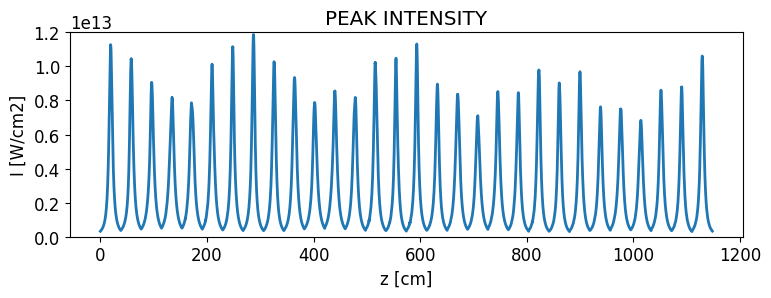

In [38]:
# PLOT PEAK INTENSITY
plt.figure(figsize=size_py_wide) 
plt.title("PEAK INTENSITY")
# plt.plot(z_total.*1e2, cat(dims=1, w_z...).*1e6)
plt.plot(z_total.*1e2, fac.*I_peak_fused)
plt.xlabel("z [cm]")
plt.ylabel("I [W/cm2]")
plt.ylim(0, 1.2e13)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "caustic.png"), dpi=res) 
end
plt.gcf()

In [39]:
# integrate peak intensity over z for each pass
I_peak_int = zeros(size(I_peak,2))
for ii = 1:size(I_peak, 2)
    I_peak_int[ii] = integrate(z, I_peak[:, ii], SimpsonEven());
end

In [40]:
n2 = params["n2"]
B_int = 2pi/λ0*n2*I_peak_int
B_int .*= PhysData.c*PhysData.ε_0/2

30-element Vector{Float64}:
 2.3092458401155973
 2.2725897045785324
 2.181765959967233
 2.1949297680055366
 2.16384723577699
 2.275841020458876
 2.2206346766141887
 2.323437102612528
 2.199822077832878
 2.2676763540285645
 ⋮
 2.1286654251213557
 1.9036799168778997
 2.0591391707785864
 1.7994855703200159
 1.9643143489298518
 1.7752441097569962
 2.0062145613571656
 1.8965887622024817
 2.212260254714939

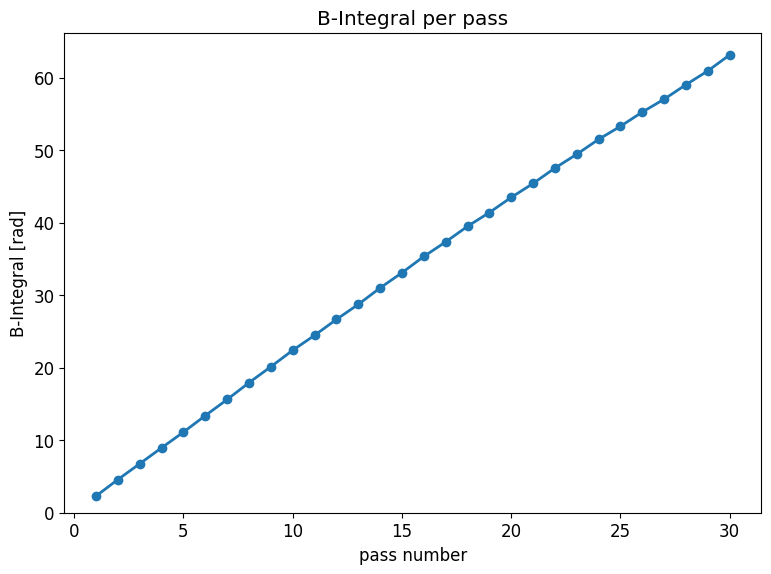

In [41]:
# PLOT B-integral per pass
plt.figure(figsize=size_py) 
plt.title("B-Integral per pass")
plt.plot(1:Npass, cumsum(B_int), marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("B-Integral [rad]")
plt.ylim(0,)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

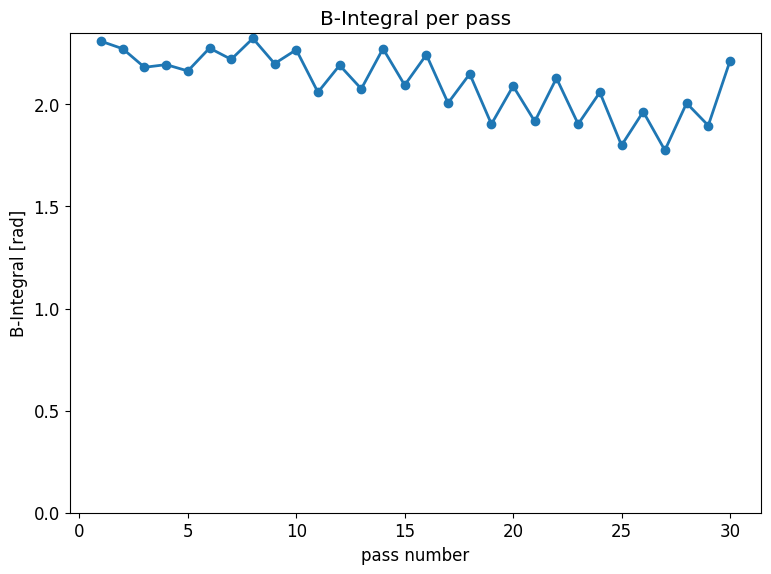

In [42]:
# PLOT B-integral per pass
plt.figure(figsize=size_py) 
plt.title("B-Integral per pass")
plt.plot(1:Npass, B_int, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("B-Integral [rad]")
plt.ylim(0,)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

In [43]:
# Expected accumulated B-Integral based on eq.8 in Viotti et al. 2022
E_pulse = params["E_pulse"]
τ = params["τ"]
k = params["k"]
Nrt = params["Npass"]/2

P_peak = 0.94*E_pulse/τ
B_pass = 4*pi^2*n2*P_peak/λ0^2*(k/Nrt)
B_total = Nrt*B_pass

println("B_pass = ", B_pass)
println("B_total = ", B_total)

B_pass = 1.727957688315069
B_total = 25.919365324726034
